# yield curve analysis

notebook for loading yield data, plotting curves, computing key spreads, applying rate shocks, and sketching a rough forward ladder.

### contents
- imports and parameters
- data load (expects `date, tenor, years, rate` with `rate` in percent)
- plotting utilities (matplotlib)
- spread calculation (2s10s, 3m10y)
- shock utilities (parallel, steepen, flatten)
- rough 1y forward ladder (toy)
- optional export of results to csv

### usage
1. set `CSV_PATH` if needed (defaults to `sample_yield_curves.csv`).
2. run the notebook top-to-bottom.
3. optional: run the final export cell to save `spreads_out.csv` and `forwards_out.csv`.


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True


In [2]:
# parameters
CSV_PATH = Path("sample_yield_curves.csv")  # columns: date, tenor, years, rate (percent)
SPREAD_TARGETS = {"2y": 2.0, "10y": 10.0, "3m": 0.25}


In [3]:
# data load
df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date']).dt.date
df['years'] = df['years'].astype(float)
df['rate'] = df['rate'].astype(float)
df = df.sort_values(['date','years']).reset_index(drop=True)
df.head()


,date,tenor,years,rate
0,2025-09-01,3M,0.25,5.20
1,2025-09-01,6M,0.50,5.10
2,2025-09-01,1Y,1.00,4.95
3,2025-09-01,2Y,2.00,4.65
4,2025-09-01,3Y,3.00,4.45


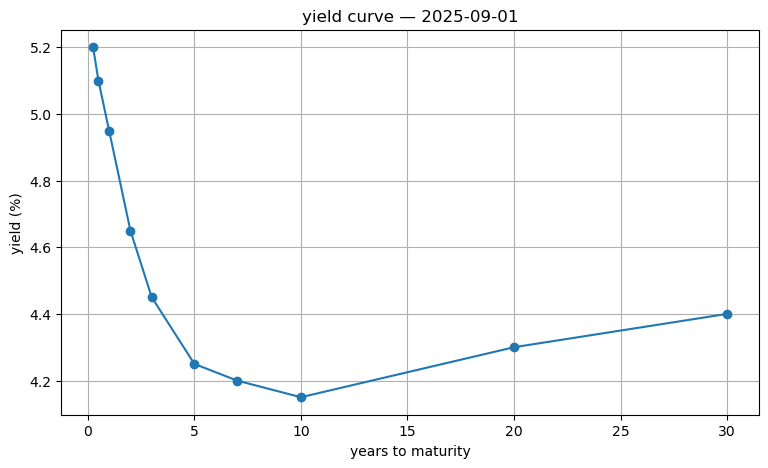

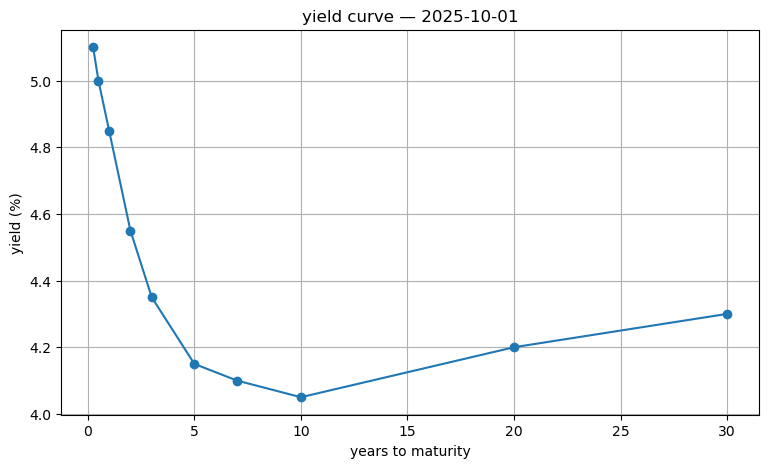

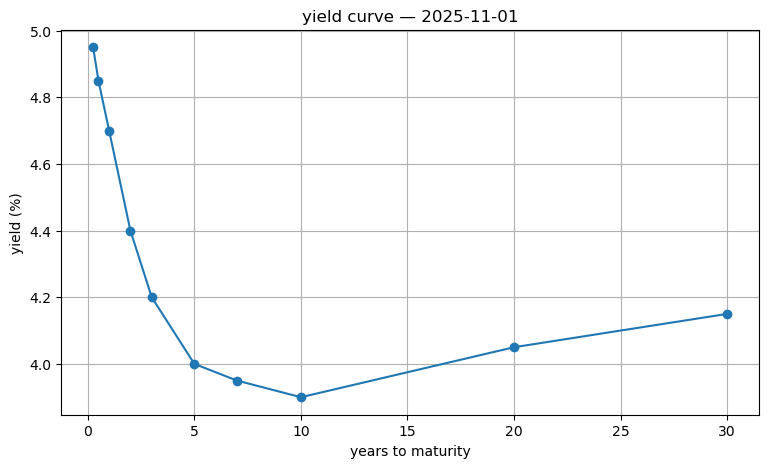

In [4]:
# plotting
def plot_curves(dframe, title_prefix="yield curve"):
    for d, sub in dframe.groupby('date'):
        plt.figure()
        plt.plot(sub['years'], sub['rate'], marker='o')
        plt.xlabel('years to maturity')
        plt.ylabel('yield (%)')
        plt.title(f"{title_prefix} — {d}")
        plt.show()

plot_curves(df)


In [5]:
# spreads
def nearest_rate_by_maturity(dframe, maturity_years, tol=0.01):
    out = []
    for d, sub in dframe.groupby('date'):
        idx = (sub['years'] - maturity_years).abs().idxmin()
        if abs(sub.loc[idx, 'years'] - maturity_years) <= tol or tol is None:
            out.append({'date': d, 'rate': sub.loc[idx, 'rate']})
        else:
            out.append({'date': d, 'rate': np.nan})
    return pd.DataFrame(out)

def compute_spreads(dframe):
    r2 = nearest_rate_by_maturity(dframe, SPREAD_TARGETS['2y'])
    r10 = nearest_rate_by_maturity(dframe, SPREAD_TARGETS['10y'])
    r3m = nearest_rate_by_maturity(dframe, SPREAD_TARGETS['3m'])
    m = r10.merge(r2, on='date', suffixes=('_10y','_2y')).merge(r3m, on='date')
    m = m.rename(columns={'rate':'rate_3m'})
    m['2s10s_bp'] = (m['rate_10y'] - m['rate_2y']) * 100
    m['3m10y_bp'] = (m['rate_10y'] - m['rate_3m']) * 100
    return m.sort_values('date')

spreads = compute_spreads(df)
spreads


,date,rate_10y,rate_2y,rate_3m,2s10s_bp,3m10y_bp
0,2025-09-01,4.15,4.65,5.20,-50.0,-105.0
1,2025-10-01,4.05,4.55,5.10,-50.0,-105.0
2,2025-11-01,3.90,4.40,4.95,-50.0,-105.0


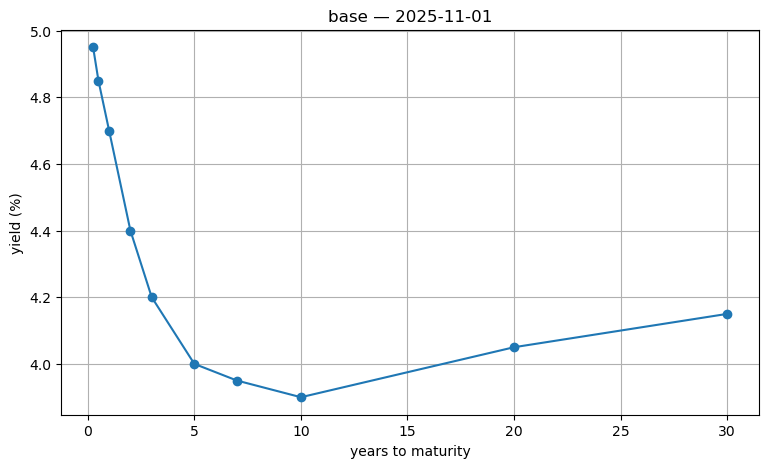

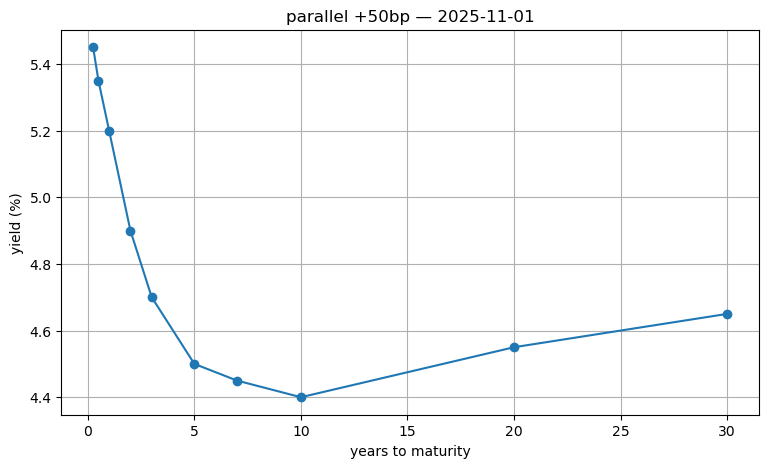

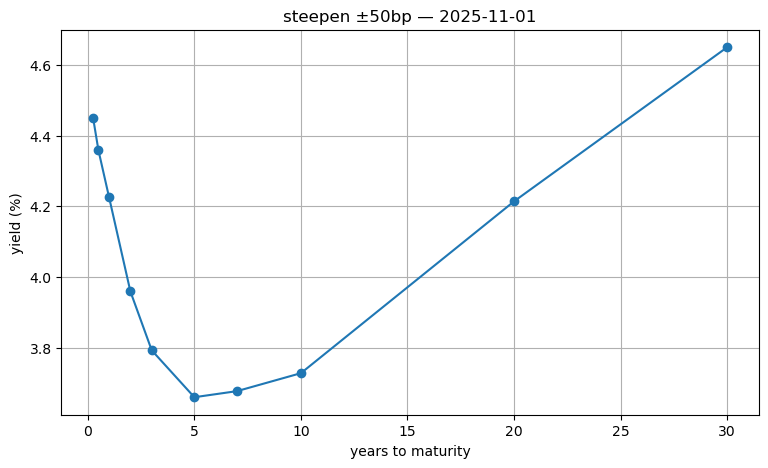

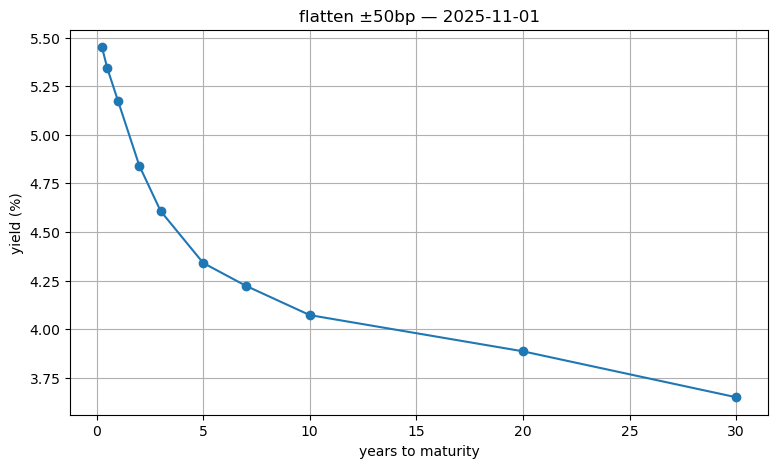

In [6]:
# shocks
def shock_parallel(dframe, bp=25):
    out = dframe.copy()
    out['rate'] = out['rate'] + bp/100
    return out

def _linear_ramp(years_series, low_year=0.25, high_year=30.0):
    y = years_series.astype(float)
    ramp = (y - low_year) / (high_year - low_year)
    return np.clip(ramp, 0.0, 1.0)

def shock_steepen(dframe, bp=25):
    out = dframe.copy()
    ramp = _linear_ramp(out['years'])
    twist = -bp*(1 - ramp) + bp*(ramp)
    out['rate'] = out['rate'] + twist/100
    return out

def shock_flatten(dframe, bp=25):
    out = dframe.copy()
    ramp = _linear_ramp(out['years'])
    twist = bp*(1 - ramp) - bp*(ramp)
    out['rate'] = out['rate'] + twist/100
    return out

# example
latest = df['date'].max()
base = df[df['date'] == latest]
for label, dsub in {
    'base': base,
    'parallel +50bp': shock_parallel(base, 50),
    'steepen ±50bp': shock_steepen(base, 50),
    'flatten ±50bp': shock_flatten(base, 50),
}.items():
    plt.figure()
    plt.plot(dsub['years'], dsub['rate'], marker='o')
    plt.xlabel('years to maturity')
    plt.ylabel('yield (%)')
    plt.title(f"{label} — {latest}")
    plt.show()


In [7]:
# rough 1y forward ladder (toy)
def rough_forward_1y_ladder(curve_one_date):
    sub = curve_one_date.sort_values('years').copy()
    out = []
    yrs = set(sub['years'])
    for t in range(1, int(np.floor(sub['years'].max()))):
        if t in yrs and (t+1) in yrs:
            yt = float(sub.loc[sub['years']==t, 'rate'])/100
            yt1 = float(sub.loc[sub['years']==t+1, 'rate'])/100
            f = ((1+yt1)**(t+1) / (1+yt)**t) - 1
            out.append({'year_start': t, 'year_end': t+1, 'fwd_1y_%': f*100})
    return pd.DataFrame(out)

fwd_1y = rough_forward_1y_ladder(base)
fwd_1y


C:\Users\Jett\AppData\Local\Temp\ipykernel_25112\2453503697.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yt = float(sub.loc[sub['years']==t, 'rate'])/100
C:\Users\Jett\AppData\Local\Temp\ipykernel_25112\2453503697.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yt1 = float(sub.loc[sub['years']==t+1, 'rate'])/100


,year_start,year_end,fwd_1y_%
0,1,2,4.100860
1,2,3,3.801149


In [ ]:
# export results
spreads.to_csv("spreads_out.csv", index=False)
fwd_1y.to_csv("forwards_out.csv", index=False)
print("wrote:", Path("spreads_out.csv").resolve())
print("wrote:", Path("forwards_out.csv").resolve())
